In [644]:
# Import required packages
import numpy as np
import pandas as pd
import cv2 as cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [307]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


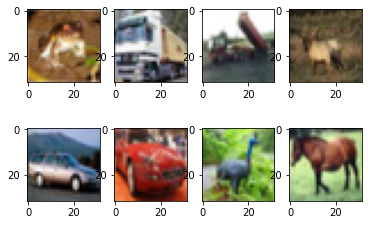

In [498]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [5]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [6]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [7]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

In [194]:
train_lab=(noisy_labels).reshape(noisy_labels.shape[0],1)
train_lab_c=(clean_labels).reshape(clean_labels.shape[0],1)

### 2.2. Model I

In [446]:
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [283]:
import tensorflow as tf 
from tensorflow import keras 
import numpy as np 
import matplotlib.pyplot as plt 
import sys 

from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from time import time 

In [374]:

def normalize(train,test,valid):
    # convert from integers to float 
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    valid_norm = valid.astype('float32')
    #normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    valid_norm = valid_norm / 255.0
    return train_norm, test_norm,valid_norm 



# plot diagnostic learning curves
def summarize_diagnostics(history):
    plt.subplots(figsize = (7,7))
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='accuracy')
    plt.plot(history.history['val_loss'], color='orange', label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')


    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='accuracy')
    plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()



In [443]:
def clean_model1():
    model1=Sequential()
    model1.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(32,32,3),padding='same'))
    model1.add(LeakyReLU(alpha=0.1))
    model1.add(MaxPool2D((2, 2),padding='same'))
    model1.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    model1.add(LeakyReLU(alpha=0.1))
    model1.add(MaxPool2D(pool_size=(2, 2),padding='same'))
    model1.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    model1.add(LeakyReLU(alpha=0.1))                  
    model1.add(MaxPool2D(pool_size=(2, 2),padding='same'))
    model1.add(Flatten())
    model1.add(Dense(128, activation='linear'))
    model1.add(LeakyReLU(alpha=0.1))                  
    #model1.add(Dense(10, activation='softmax'))
    #model1.add(Flatten())
    model1.add(Dense(64, activation='relu'))
    model1.add(Dense(10))
    return model1
    

Epoch 1/10
1250/1250 [==============================] - 42s 33ms/step - loss: 2.2702 - accuracy: 0.1534 - val_loss: 2.2434 - val_accuracy: 0.1886
Epoch 2/10
1250/1250 [==============================] - 56s 45ms/step - loss: 2.2293 - accuracy: 0.2016 - val_loss: 2.2290 - val_accuracy: 0.2028
Epoch 3/10
1250/1250 [==============================] - 48s 39ms/step - loss: 2.1964 - accuracy: 0.2304 - val_loss: 2.2260 - val_accuracy: 0.2128
Epoch 4/10
1250/1250 [==============================] - 67s 54ms/step - loss: 2.1631 - accuracy: 0.2517 - val_loss: 2.2189 - val_accuracy: 0.2297
Epoch 5/10
1250/1250 [==============================] - 119s 95ms/step - loss: 2.1191 - accuracy: 0.2767 - val_loss: 2.2147 - val_accuracy: 0.2376
Epoch 6/10
1250/1250 [==============================] - 246s 197ms/step - loss: 2.0512 - accuracy: 0.3035 - val_loss: 2.2560 - val_accuracy: 0.2282
Epoch 7/10
1250/1250 [==============================] - 173s 139ms/step - loss: 1.9523 - accuracy: 0.3413 - val_loss: 2.3

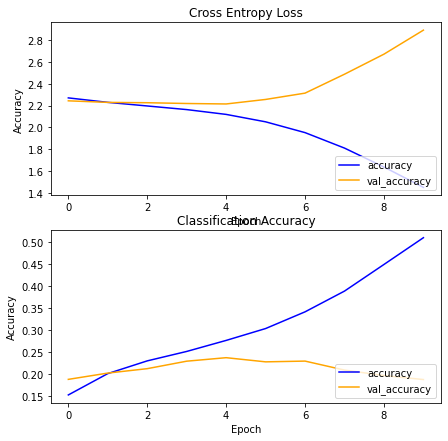

In [453]:

trainX, testX, trainY, testY = train_test_split(imgs, train_lab, 
                                                           test_size=0.2, random_state=13)    #get validation set 
valid_X = []
valid_Y = []
#trainX,  validX,trainY, validY = train_test_split(trainX,trainY,test_size=0.25)
    
    # normalize the data
trainX, testX,validX = normalize(trainX, testX,validX)
    # define model

model1=clean_model1()
model1.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model1.fit(trainX,trainY,  epochs=10, validation_data=(testX, testY))
    # evaluate model
_, acc = model1.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))
    # learning curves
summarize_diagnostics(history)



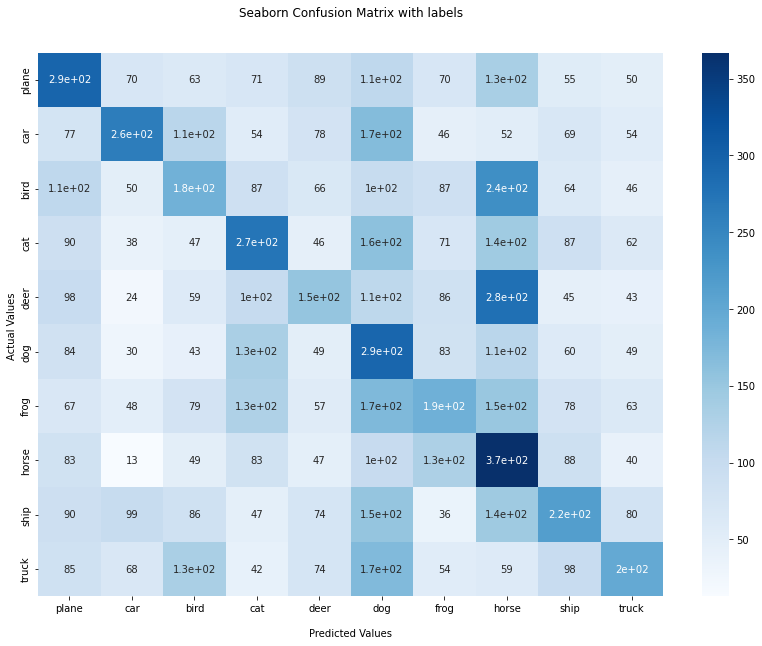

In [671]:
labels_pred = np.argmax(model1.predict(imgs[:10000]), axis = 1)
cf_matrix = confusion_matrix(clean_labels, labels_pred)

plt.figure(figsize=(14, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

## Display the visualization of the Confusion Matrix.
plt.show()


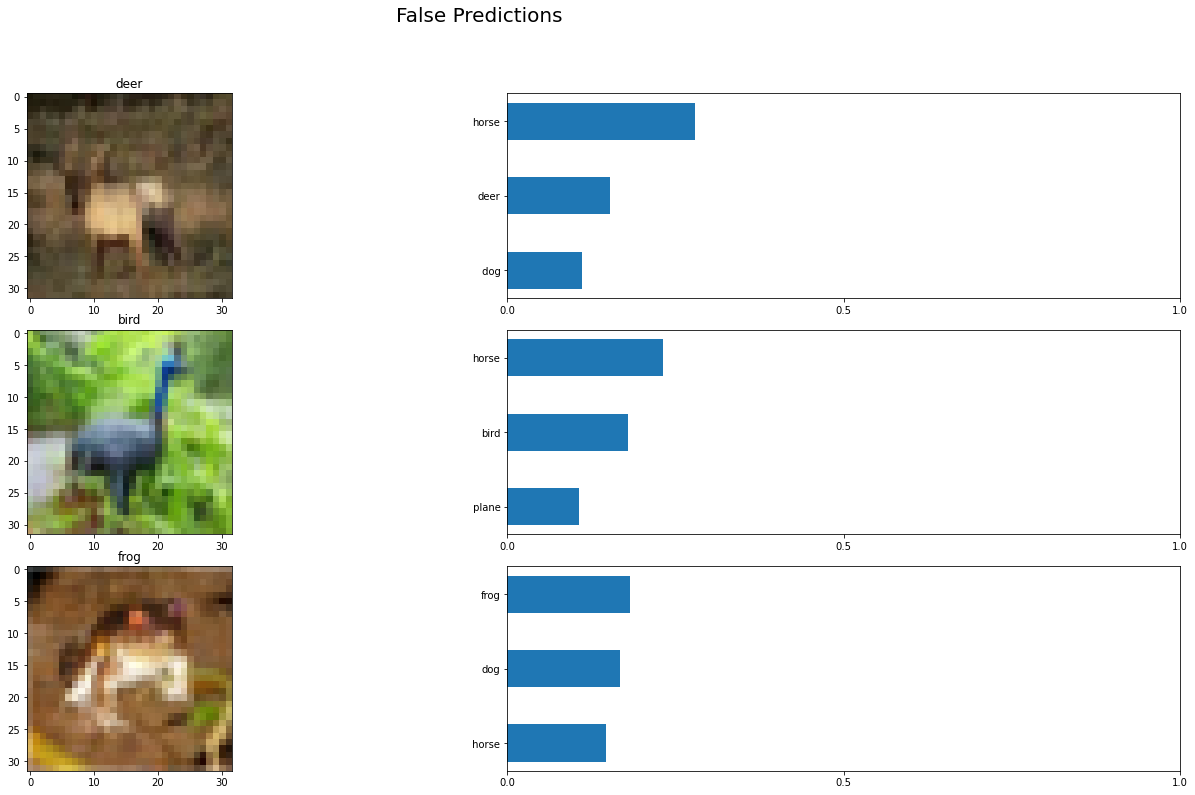

In [673]:
np.argmin(np.diagonal(cf_matrix))

fig, axies = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
fig.tight_layout()
fig.suptitle('False Predictions', fontsize=20, y=1.1)

n_predictions = 3
margin = 0.05
ind = np.arange(n_predictions)
width = (1. - 2. * margin) / n_predictions
# consider 3 most common prediction mistake for the actual picture that has badest prediction performance(class bad)
n_top=3 
j=0
#,cf_matrix= pd.DataFrame(cf_matrix)
for i in np.diagonal(cf_matrix).argsort()[:n_predictions]:
    #cf_matrix0=cf_matrix.drop(i,axis=1)
    h=[np.where(clean_labels==[i])][0][0][0]
    axies[j][0].imshow(imgs[h]/255)
    axies[j][0].set_title(classes[i])
    pre=" "
    for bad in cf_matrix[i,].argsort()[::-1][:n_top][::-1]:
        pre=pre+(classes[bad])+","
    pre=pre.split(',')
    axies[j][1].barh(pre[:n_top],(np.sort(cf_matrix[i,])[-n_top:])/cf_matrix[i,].sum(),0.5)
    axies[j][1].set_yticks(pre[:n_top])
   # axies[j][1].set_yticklabels()
    axies[j][1].set_xticks([0, 0.5, 1.0])
    j=j+1
    





In [667]:
classes[4]
cf_matrix.drop(4,axis=1)
cf_matrix0.iloc[4,].argsort()[::-1][:n_top][::-1]

7    3
8    4
9    6
Name: 4, dtype: int64

<BarContainer object of 3 artists>

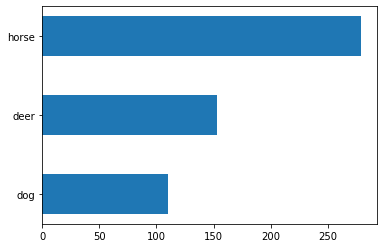

In [634]:
# consider 3 most common prediction mistake for the actual picture that has badest prediction performance(class bad)
n_top=3 
pre=""
for bad in cf_matrix[4,].argsort()[::-1][:n_top][::-1]:
    pre=pre+(classes[bad])+","
pre=pre.split(',')
plt.barh(pre[:n_top],np.sort(cf_matrix[4,])[-n_top:],0.5)

## Model2

Without using data augmentation

Epoch 1/10
250/250 [==============================] - 9s 30ms/step - loss: 1.8901 - accuracy: 0.2956 - val_loss: 1.5678 - val_accuracy: 0.4205
Epoch 2/10
250/250 [==============================] - 8s 31ms/step - loss: 1.4650 - accuracy: 0.4624 - val_loss: 1.4204 - val_accuracy: 0.4795
Epoch 3/10
250/250 [==============================] - 9s 35ms/step - loss: 1.2355 - accuracy: 0.5529 - val_loss: 1.1936 - val_accuracy: 0.5570
Epoch 4/10
250/250 [==============================] - 8s 33ms/step - loss: 1.0507 - accuracy: 0.6176 - val_loss: 1.1488 - val_accuracy: 0.5860
Epoch 5/10
250/250 [==============================] - 8s 33ms/step - loss: 0.8730 - accuracy: 0.6852 - val_loss: 1.0498 - val_accuracy: 0.6265
Epoch 6/10
250/250 [==============================] - 8s 32ms/step - loss: 0.7333 - accuracy: 0.7341 - val_loss: 1.1834 - val_accuracy: 0.5990
Epoch 7/10
250/250 [==============================] - 8s 32ms/step - loss: 0.5646 - accuracy: 0.8009 - val_loss: 1.1623 - val_accuracy: 0.6350

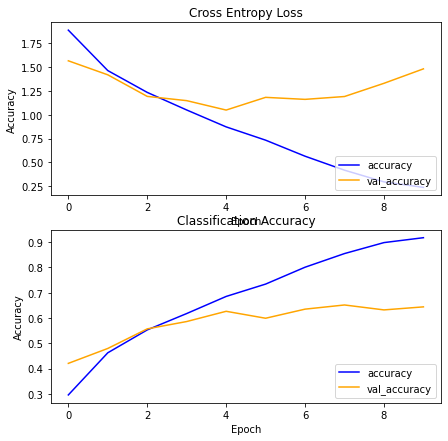

In [421]:
trainX, testX, trainY, testY = train_test_split(imgs[:10000], train_lab_c, 
                                                           test_size=0.2, random_state=13)    #get validation set 
valid_X = []
valid_Y = []
#trainX,  validX,trainY, validY = train_test_split(trainX,trainY,test_size=0.25)
    
    # normalize the data
trainX, testX, validX = normalize(trainX, testX,validX)
    # define model
    #create data generator 
#datagen = ImageDataGenerator(width_shift_range = 0.05, height_shift_range = 0.05, horizontal_flip = True)
#datagen.fit(trainX)
    #iterator 
#train = datagen.flow(trainX, trainY, batch_size = 64)
model1=clean_model1()
model1.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model1.fit(trainX,trainY,epochs=10, validation_data=(testX, testY))
    # evaluate model
_, acc = model1.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))
    # learning curves
summarize_diagnostics(history)



In [422]:
model1.evaluate(testX, testY, verbose=0)

[1.4830094575881958, 0.6439999938011169]

In [426]:
y_pred=model1.predict(imgs[10000:])
y_pred_class=[np.argmax(element) for element in y_pred ]
p=np.array(y_pred_class)
train_lab_p=(p).reshape(p.shape[0],1)
train_lab_n=np.concatenate((trainY,train_lab_p),axis=0)

In [436]:
a=imgs[10000:].astype('float32')/255.00
train_X_n=np.concatenate((trainX,a),axis=0)
b=imgs[:10000].astype('float32')/255.00
train_lab_all=np.concatenate((train_lab_c,train_lab_p),axis=0)
train_X_all=np.concatenate((b,a),axis=0)
train_X2,test_X2,train_Y2,test_Y2=train_test_split(train_X_all, train_lab_all, 
                                                           test_size=0.2, random_state=13)   



Epoch 1/10
1250/1250 [==============================] - 73s 57ms/step - loss: 1.2538 - accuracy: 0.5547 - val_loss: 0.9722 - val_accuracy: 0.6542
Epoch 2/10
1250/1250 [==============================] - 129s 104ms/step - loss: 0.8896 - accuracy: 0.6838 - val_loss: 0.9387 - val_accuracy: 0.6731
Epoch 3/10
1250/1250 [==============================] - 227s 182ms/step - loss: 0.7578 - accuracy: 0.7298 - val_loss: 0.9016 - val_accuracy: 0.6802
Epoch 4/10
1250/1250 [==============================] - 264s 211ms/step - loss: 0.6552 - accuracy: 0.7686 - val_loss: 0.8798 - val_accuracy: 0.6967
Epoch 5/10
1250/1250 [==============================] - 201s 161ms/step - loss: 0.5586 - accuracy: 0.8000 - val_loss: 0.8836 - val_accuracy: 0.7063
Epoch 6/10
1250/1250 [==============================] - 183s 147ms/step - loss: 0.4630 - accuracy: 0.8350 - val_loss: 0.9613 - val_accuracy: 0.6940
Epoch 7/10
1250/1250 [==============================] - 48s 38ms/step - loss: 0.3839 - accuracy: 0.8620 - val_loss

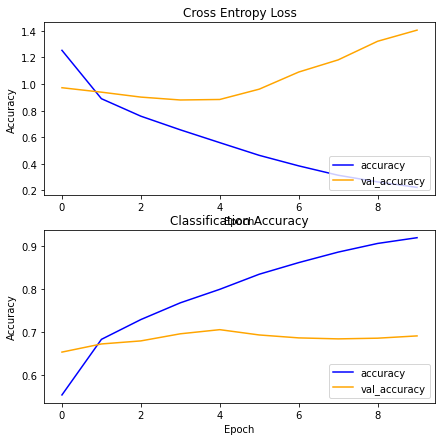

In [444]:
model1=clean_model1()
model1.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model1.fit(train_X2, train_Y2, epochs=10, 
                    validation_data=(test_X2, test_Y2))

_, acc = model1.evaluate(test_X2, test_Y2, verbose=0)
print('> %.3f' % (acc * 100.0))
    # learning curves
summarize_diagnostics(history2)

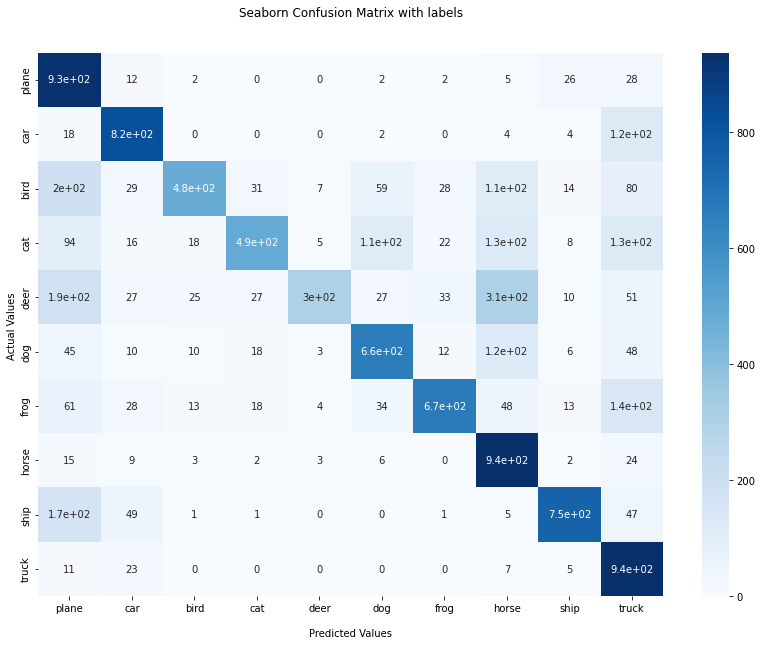

In [451]:
labels_pred = np.argmax(model1.predict(imgs[:10000]), axis = 1)
cf_matrix = confusion_matrix(clean_labels, labels_pred)

plt.figure(figsize=(14, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

## Display the visualization of the Confusion Matrix.
plt.show()

In [7]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# write your code here...

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

### 2.3. Model II

In [8]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [10]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [11]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

FileNotFoundError: ../data/test_labels.csv not found.

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.